In [1]:
import pandas as pd
import numpy as np

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

# tracking and versioning by mlflow
import mlflow
import mlflow.sklearn

# set experiment name
mlflow.set_experiment('bracelet')

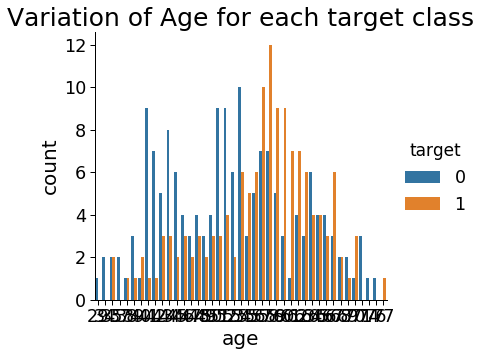

In [2]:
df = pd.read_csv('cleveland.csv', header = None)

df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'target']

### 1 = male, 0 = female
df.isnull().sum()

df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df['sex'] = df.sex.map({0: 'female', 1: 'male'})
df['thal'] = df.thal.fillna(df.thal.mean())
df['ca'] = df.ca.fillna(df.ca.mean())
df['sex'] = df.sex.map({'female': 0, 'male': 1})

import matplotlib.pyplot as plt
import seaborn as sns

# distribution of target vs age 
sns.set_context("paper", font_scale = 2, rc = {"font.size": 20,"axes.titlesize": 25,"axes.labelsize": 20}) 
sns.catplot(kind = 'count', data = df, x = 'age', hue = 'target', order = df['age'].sort_values().unique())
plt.title('Variation of Age for each target class')
plt.savefig('distribution_target_vs_age.png')
plt.show() 

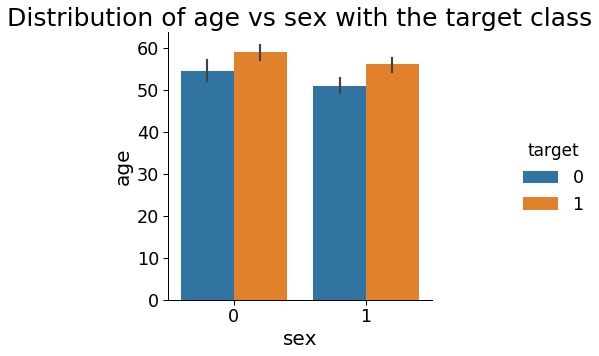

In [3]:
# barplot of age vs sex with hue = target
sns.catplot(kind = 'bar', data = df, y = 'age', x = 'sex', hue = 'target')
plt.title('Distribution of age vs sex with the target class')
plt.savefig('barplot_age_vs_sex.png')
plt.show()

In [4]:
########### data preprocessing ###########

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

from sklearn.preprocessing import StandardScaler as ss
sc = ss()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [6]:
###########   Logistic Regression   ###########
def train_logistic_regression(penalty='l2', dual=False, tol=0.0001, C=1.0, max_iter=1000):
    
    with mlflow.start_run(run_name='Logistic Regression'):
        
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression(penalty=penalty, dual=dual, tol=tol, C=C, max_iter=max_iter)
        classifier.fit(X_train, y_train)

        # Predicting the Test set results
        y_pred = classifier.predict(X_test)

        from sklearn.metrics import confusion_matrix
        cm_test = confusion_matrix(y_pred, y_test)

        y_pred_train = classifier.predict(X_train)
        cm_train = confusion_matrix(y_pred_train, y_train)
        
        accuracy_test_set = (cm_test[0][0] + cm_test[1][1])/len(y_test)
        accuracy_training_set = (cm_train[0][0] + cm_train[1][1])/len(y_train)
        (rmse, mae, r2) = eval_metrics(y_test, y_pred)
        
        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("penalty", penalty)
        mlflow.log_param("dual", dual)
        mlflow.log_param("tol", tol)
        mlflow.log_param("C", C)
        mlflow.log_param("max_iter", max_iter)
        
        mlflow.log_metric("Accuracy", accuracy_test_set)
        mlflow.log_metric("Accuracy TrainingSet", accuracy_training_set)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        
        # Add tag to MLflow log
        mlflow.set_tag('model', 'Logistic Regression')
        mlflow.set_tag('stage', 'experimental')
        
        # save plot in the artifacts pool
        mlflow.log_artifact('barplot_age_vs_sex.png','analysis')

        # save plot in the artifacts pool
        mlflow.log_artifact('distribution_target_vs_age.png','analysis')
        
        # Add DataSet to artifacts
        mlflow.log_artifact('./cleveland.csv')
        
        mlflow.sklearn.log_model(classifier, "model")
        
        # Print out metrics
        print("Logistic Regression model (penalty=%s, dual=%s, tol=%s, c=%s, max_iter=%s):" % (penalty, dual, tol, C, max_iter))
        print('  Accuracy for TestSet %s' % accuracy_test_set)
        print('  Accuracy for TrainingSet %s' % accuracy_training_set)
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

In [7]:
train_logistic_regression()

Logistic Regression model (penalty=l2, dual=False, tol=0.0001, c=1.0, max_iter=1000):
  Accuracy for TestSet 0.7868852459016393
  Accuracy for TrainingSet 0.859504132231405
  RMSE: 0.4616435357484827
  MAE: 0.21311475409836064
  R2: 0.12857142857142856


In [8]:
train_logistic_regression(tol=0.0000001, C=4.0, max_iter=6000)

Logistic Regression model (penalty=l2, dual=False, tol=1e-07, c=4.0, max_iter=6000):
  Accuracy for TestSet 0.7868852459016393
  Accuracy for TrainingSet 0.8636363636363636
  RMSE: 0.4616435357484827
  MAE: 0.21311475409836064
  R2: 0.12857142857142856
